# cora_geniepath_v1_loss

Epoch: 001,train_loss:1.0991530418395996, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 002,train_loss:1.0979838371276855, Train: 0.3333, Val: 0.3900, Test: 0.4130
Epoch: 003,train_loss:1.0970289707183838, Train: 0.5167, Val: 0.4280, Test: 0.4200
Epoch: 004,train_loss:1.0957348346710205, Train: 0.3333, Val: 0.4160, Test: 0.4070
Epoch: 005,train_loss:1.0932832956314087, Train: 0.6333, Val: 0.5360, Test: 0.5060
Epoch: 006,train_loss:1.087320327758789, Train: 0.8167, Val: 0.5180, Test: 0.5080
Epoch: 007,train_loss:1.0717315673828125, Train: 0.7667, Val: 0.5800, Test: 0.5830
Epoch: 008,train_loss:1.027691125869751, Train: 0.8000, Val: 0.5780, Test: 0.5630
Epoch: 009,train_loss:0.9052249193191528, Train: 0.6833, Val: 0.5680, Test: 0.5320
Epoch: 010,train_loss:0.6782538294792175, Train: 0.7000, Val: 0.5520, Test: 0.5310
Epoch: 011,train_loss:0.5704870223999023, Train: 0.6500, Val: 0.5500, Test: 0.5240
Epoch: 012,train_loss:0.7353090643882751, Train: 0.7167, Val: 0.5920, Test: 0.5600
Epoch:

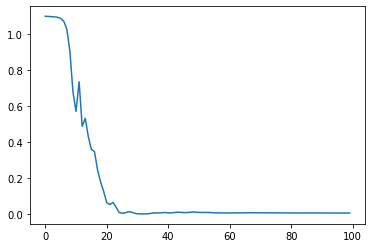

CPU times: user 17.2 s, sys: 5.04 s, total: 22.3 s
Wall time: 19 s


4755003

In [27]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

dim = dataset.num_features
lstm_hidden = dataset.num_features
layer_num = 2#这只要超过2，就没有效果了，准确率会很低


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(in_dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()

#     total_loss = 0
    # for data in train_loader:
    # num_graphs = data.num_graphs
    # data.batch = None
    # data = data.to(device)
    optimizer.zero_grad()
    # loss = loss_op(model(data.x, data.edge_index), data.y)
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # loss = F.cross_entropy(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask])
    # total_loss += loss.item() * num_graphs
#     total_loss += loss.item() 
    loss.backward()
    optimizer.step()
    return loss.item()


# def test(loader):
#     model.eval()

#     ys, preds = [], []
#     for data in loader:
#         ys.append(data.y)
#         with torch.no_grad():
#             out = model(data.x.to(device), data.edge_index.to(device))
#         preds.append((out > 0).float().cpu())

#     y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
#     return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pub_genie=[]
for epoch in range(1, 101):
    loss = train()
    losslist_pub_genie.append(loss)
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_genie)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# cora_AGNN

Epoch: 001,Train_loss:1.0984472036361694, Train: 0.4000, Val: 0.4000, Test: 0.4210
Epoch: 002,Train_loss:1.0982571840286255, Train: 0.3333, Val: 0.4000, Test: 0.4210
Epoch: 003,Train_loss:1.094688892364502, Train: 0.4000, Val: 0.4000, Test: 0.4210
Epoch: 004,Train_loss:1.0908678770065308, Train: 0.5667, Val: 0.4000, Test: 0.4210
Epoch: 005,Train_loss:1.0897163152694702, Train: 0.7000, Val: 0.4940, Test: 0.4630
Epoch: 006,Train_loss:1.0864131450653076, Train: 0.8833, Val: 0.6780, Test: 0.6460
Epoch: 007,Train_loss:1.083828091621399, Train: 0.9000, Val: 0.7200, Test: 0.6930
Epoch: 008,Train_loss:1.076093316078186, Train: 0.9167, Val: 0.7220, Test: 0.7010
Epoch: 009,Train_loss:1.0689187049865723, Train: 0.9333, Val: 0.7260, Test: 0.7050
Epoch: 010,Train_loss:1.0669111013412476, Train: 0.9167, Val: 0.7260, Test: 0.7050
Epoch: 011,Train_loss:1.0676988363265991, Train: 0.9000, Val: 0.7360, Test: 0.6950
Epoch: 012,Train_loss:1.0469073057174683, Train: 0.9000, Val: 0.7360, Test: 0.6950
Epoch: 

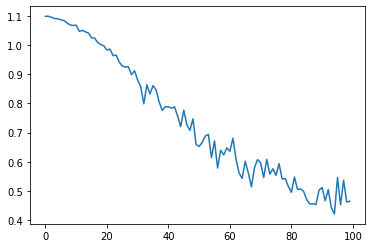

CPU times: user 3.89 s, sys: 332 ms, total: 4.22 s
Wall time: 1.68 s


8068

In [28]:
%%time
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import AGNNConv

dataset = 'Pubmed'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = torch.nn.Linear(dataset.num_features, 16)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(16, dataset.num_classes)

    def forward(self):
        x = F.dropout(data.x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, data.edge_index)
        x = self.prop2(x, data.edge_index)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    loss=F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
losslist_pub_agnn=[]
for epoch in range(1, 101):
    loss=train()
    losslist_pub_agnn.append(loss)
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d},Train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch,loss, train_acc, best_val_acc, test_acc))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_agnn)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# cora_GAT 

Epoch: 001,Train_loss:1.0961302518844604, Train: 0.5000, Val: 0.5440, Test: 0.5290
Epoch: 002,Train_loss:1.0938085317611694, Train: 0.6333, Val: 0.5460, Test: 0.5360
Epoch: 003,Train_loss:1.0906280279159546, Train: 0.6333, Val: 0.5360, Test: 0.5320
Epoch: 004,Train_loss:1.078521966934204, Train: 0.6667, Val: 0.5820, Test: 0.5660
Epoch: 005,Train_loss:1.0766983032226562, Train: 0.8167, Val: 0.6820, Test: 0.6540
Epoch: 006,Train_loss:1.0716915130615234, Train: 0.8833, Val: 0.7220, Test: 0.7020
Epoch: 007,Train_loss:1.065155267715454, Train: 0.8833, Val: 0.7340, Test: 0.7160
Epoch: 008,Train_loss:1.0470880270004272, Train: 0.9000, Val: 0.7180, Test: 0.7240
Epoch: 009,Train_loss:1.0507464408874512, Train: 0.9000, Val: 0.7160, Test: 0.7130
Epoch: 010,Train_loss:1.0430757999420166, Train: 0.8833, Val: 0.6920, Test: 0.6890
Epoch: 011,Train_loss:1.033520221710205, Train: 0.9167, Val: 0.6900, Test: 0.6840
Epoch: 012,Train_loss:1.0300573110580444, Train: 0.9167, Val: 0.7180, Test: 0.7120
Epoch: 

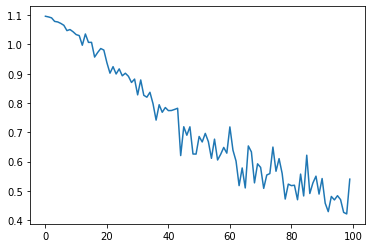

CPU times: user 4.54 s, sys: 453 ms, total: 4.99 s
Wall time: 2.46 s


32393

In [25]:
%%time
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

dataset = 'Pubmed'
path = osp.join('./', '..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(
            8 * 8, dataset.num_classes, heads=1, concat=True, dropout=0.6)

    def forward(self):
        x = F.dropout(data.x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, data.edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
#     total_loss = 0

    optimizer.zero_grad()
    #损失函数NLLLoss() 的 输入 是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，
    # 适合最后一层是log_softmax()的网络（28行）. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似, 
    # 唯一的不同是它为我们去做 softmax.可以理解为：
    # CrossEntropyLoss()=log_softmax() + NLLLoss() 

    #model()每个点都给出预测结果，但这里只取train_mask
    loss=F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
#     total_loss+=loss.item()
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pub_GAT=[]
for epoch in range(1, 101):
    loss=train()
    losslist_pub_GAT.append(loss)
    log = 'Epoch: {:03d},Train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_GAT)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

In [106]:
for _, mask in data('train_mask', 'val_mask', 'test_mask'):
    print(mask.sum().item())
data.train_mask.sum().item()

140
500
1000


140

# cora_sgeniepath_AGNN

Epoch: 001,train_loss:1.099053144454956, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 002,train_loss:1.098041296005249, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 003,train_loss:1.09702730178833, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 004,train_loss:1.0956279039382935, Train: 0.3333, Val: 0.3880, Test: 0.4130
Epoch: 005,train_loss:1.093366026878357, Train: 0.6833, Val: 0.4960, Test: 0.5170
Epoch: 006,train_loss:1.089483380317688, Train: 0.9333, Val: 0.7420, Test: 0.7240
Epoch: 007,train_loss:1.0827362537384033, Train: 0.9333, Val: 0.7080, Test: 0.6620
Epoch: 008,train_loss:1.0712229013442993, Train: 0.8833, Val: 0.6460, Test: 0.6250
Epoch: 009,train_loss:1.0523386001586914, Train: 0.8833, Val: 0.6260, Test: 0.6040
Epoch: 010,train_loss:1.0229476690292358, Train: 0.8833, Val: 0.6320, Test: 0.6100
Epoch: 011,train_loss:0.9798648953437805, Train: 0.8833, Val: 0.6500, Test: 0.6150
Epoch: 012,train_loss:0.9206843972206116, Train: 0.8667, Val: 0.6560, Test: 0.6180
Epoch: 013

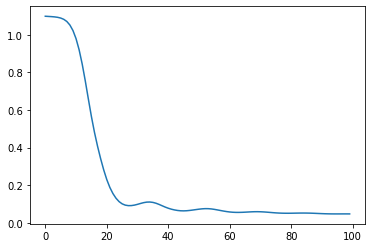

CPU times: user 14.2 s, sys: 4.3 s, total: 18.5 s
Wall time: 15.3 s


4252005

In [24]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import AGNNConv

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePath')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

# path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
# train_dataset = PPI(path, split='train')
# val_dataset = PPI(path, split='val')
# test_dataset = PPI(path, split='test')
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dataset = 'Pubmed'
path = osp.join('./', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

dim = dataset.num_features
lstm_hidden = dataset.num_features
layer_num = 2#这只要超过2，就没有效果了，准确率会很低


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
#         self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        self.gatconv = AGNNConv(requires_grad=True)

        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(in_dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        # return x
        return F.log_softmax(x, dim=1)



class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
# model = kwargs[args.model](train_dataset.num_features,train_dataset.num_classes).to(device)
loss_op = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model, data = GeniePath(dataset.num_features,dataset.num_classes).to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data.x, data.edge_index)[data.train_mask], data.y[data.train_mask]) 
    loss.backward()
    optimizer.step()
    return loss 


# def test(loader):
#     model.eval()

#     ys, preds = [], []
#     for data in loader:
#         ys.append(data.y)
#         with torch.no_grad():
#             out = model(data.x.to(device), data.edge_index.to(device))
#         preds.append((out > 0).float().cpu())

#     y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
#     return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

losslist_pubmed_sgenagnn=[]
for epoch in range(1, 101):
    loss = train()
    losslist_pubmed_sgenagnn.append(loss)
    # val_f1 = test(val_loader)
    # test_f1 = test(test_loader)
    # print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
    #     epoch, loss, val_f1, test_f1))
    log = 'Epoch: {:03d},train_loss:{}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, loss,*test()))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pubmed_sgenagnn)
plt.show()
sum([torch.numel(param) for param in model.parameters()])

# 画图

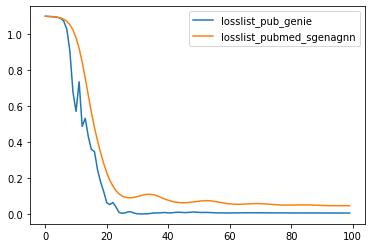

In [33]:
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_pub_genie,label="losslist_pub_genie")

plt.plot(losslist_pubmed_sgenagnn,label="losslist_pubmed_sgenagnn")
# plt.plot(losslist_pub_agnn,label="losslist_pub_agnn")
# plt.plot(losslist_pub_GAT,label="losslist_pub_GAT")


plt.legend(loc=0, ncol=1) 
plt.savefig('./pubmed数据集对比.jpg')
plt.show()